# Problem Statement :- Implementation of Twitter Sentiment Analysis using RNN



In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
import itertools

In [ ]:
train_data = pd.read_csv(r"/content/drive/MyDrive/DL + AI Exam Paper/DL + AI Exam Paper/Dataset/RNN/tweets_train.csv")
test_data = pd.read_csv(r"/content/drive/MyDrive/DL + AI Exam Paper/DL + AI Exam Paper/Dataset/RNN/tweets_test.csv")


# Changing column name for understanding

In [ ]:
train_data.rename(columns={'clean_text': 'text',}, inplace=True)
test_data.rename(columns={'clean_text': 'text',}, inplace=True)


 # Checking Distribution of Sentiments

In [ ]:
train_data.Sentiment.value_counts()

Sentiment
Positive    8059
Neutral     5927
Negative    3014
Name: count, dtype: int64

# Visualizing the distribution

<ipython-input-12-c9cce219d70a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=train_data, palette='viridis')


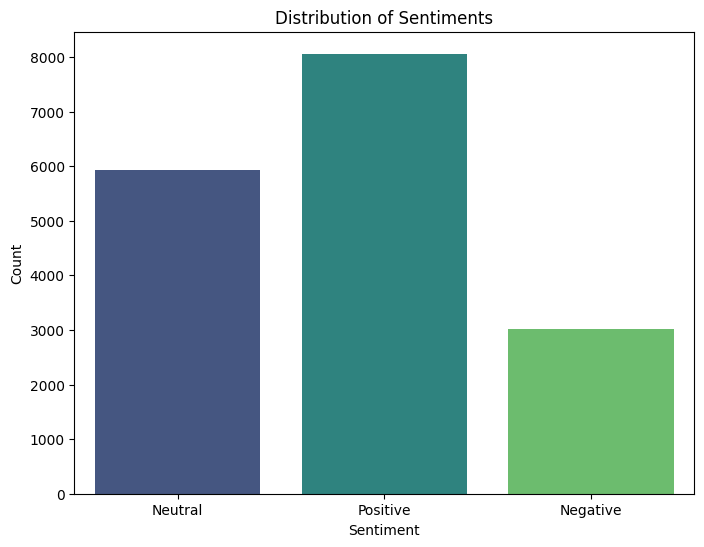

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size for better visualization
sns.countplot(x='Sentiment', data=train_data, palette='viridis')
plt.title('Distribution of Sentiments') # Add a title
plt.xlabel('Sentiment') # Add x-axis label
plt.ylabel('Count') # Add y-axis label
plt.show()

# Wordcloud

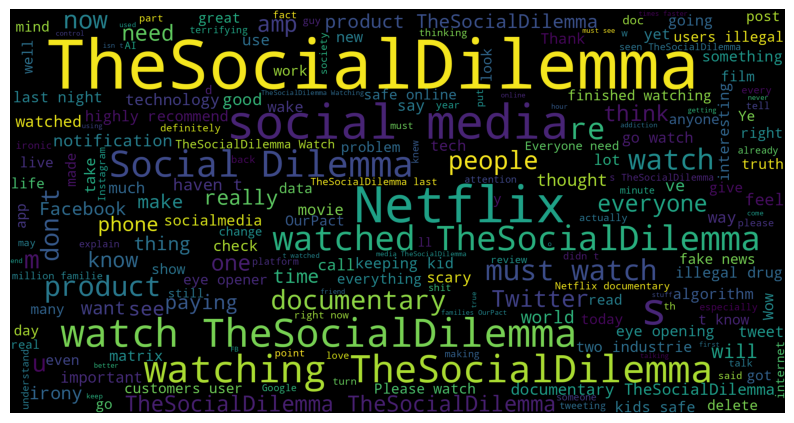

In [ ]:
# Convert all elements of the 'text' column to strings before joining.
text = " ".join(str(review) for review in train_data.text)
wordcloud = WordCloud(width=1920, height=1000).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Download stopwords

In [ ]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing

In [ ]:
def preprocess_text(text):
    """
    Preprocess text by lowercasing, removing URLs, special characters,
    and stopwords.
    """
    if not isinstance(text, str):  # Check if input is not a string
        return ''
        cleaned_text = ' '.join(tokens)
        return cleaned_text

 # Convert to lowercase

In [ ]:
 text = text.lower()

 # Remove URLs

In [ ]:
text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

 # Remove special characters and numbers

In [ ]:
text = re.sub(r'[^a-z\s]', '', text)

 # Tokenize and remove stopwords

In [ ]:
tokens = text.split()
tokens = [word for word in tokens if word not in stop_words]

# Applying the preprocess text to our data

In [ ]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

# Step 5: Encode Sentiments

In [ ]:
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])

# Tokenize text data

In [ ]:
tokenizer = Tokenizer(num_words=10000)  # Use top 10,000 words
tokenizer.fit_on_texts(train_data['text'])

# Splitting the data

In [ ]:
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])

In [ ]:
max_len = 50  # Adjust based on the dataset
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# One-hot encode target variable

In [ ]:
y_train = pd.get_dummies(train_data['Sentiment']).values


# Step 7: Train-Test Split for Validation


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 8: Build the RNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dropout, Dense, BatchNormalization
from keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),  # Embedding layer
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),  # Dropout layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.05)),  # Dense layer with L2 regularization
    BatchNormalization(),  # Batch normalization for stabilized training
    Dropout(0.3),  #  dropout layer
    Dense(3, activation='softmax')  # Output layer
])


# Step 9: Compile the Model

In [ ]:
from tensorflow.keras.regularizers import l2

model.compile(optimizer=Adam(learning_rate=0.00005 , clipnorm=1.0),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Add early stopping to prevent overfitting

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3256 - loss: 3.7008 - val_accuracy: 0.4996 - val_loss: 3.0671
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3759 - loss: 3.4136 - val_accuracy: 0.5338 - val_loss: 2.9120
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4145 - loss: 3.1693 - val_accuracy: 0.5529 - val_loss: 2.7660
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4512 - loss: 3.0174 - val_accuracy: 0.5875 - val_loss: 2.6297
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4887 - loss: 2.8200 - val_accuracy: 0.5974 - val_loss: 2.5166
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5077 - loss: 2.6715 - val_accuracy: 0.5974 - val_loss: 2.4062
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5259 - loss: 2.5325 - val_accuracy: 0.6132 - val_loss: 2.3014
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5502 - loss: 2.3897 - val_accuracy: 

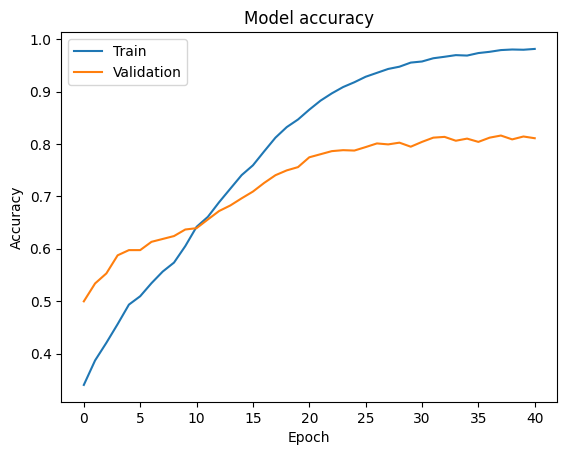

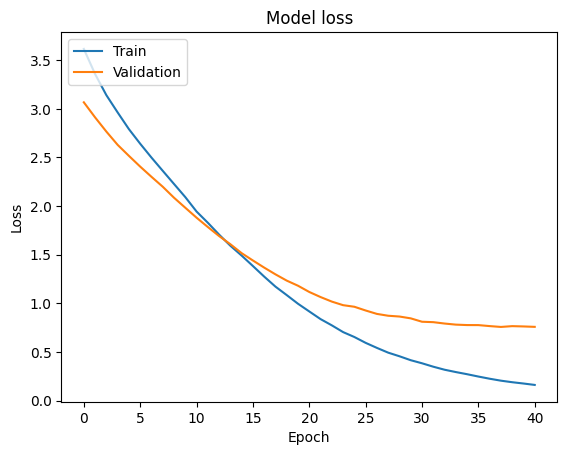

In [ ]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generating predictions

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
test_data['Predicted_Sentiment'] = label_encoder.inverse_transform(y_pred_labels)

# Testing our model

In [ ]:
def predicting_Sentiment(a):
    new_data = tokenizer.texts_to_sequences(a)
    new_data = pad_sequences(new_data, maxlen=max_len)
    output = (model.predict(new_data) >= 0.5).astype(int)
    predicted_class = np.argmax(model.predict(new_data), axis=-1)
    predicted_sentiment = label_encoder.inverse_transform(predicted_class)
    print(f"Predicted Sentiment: {predicted_sentiment[0]}")

In [ ]:
a=["watched thesocialdilemma netflix"]
predicting_Sentiment(a)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Sentiment: Neutral


# Testing with Gradio interface

In [ ]:
import gradio as gr

def predict_sentiment(text):
    new_data = tokenizer.texts_to_sequences([text])
    new_data = pad_sequences(new_data, maxlen=max_len)
    predicted_class = np.argmax(model.predict(new_data), axis=-1)
    predicted_sentiment = label_encoder.inverse_transform(predicted_class)
    return predicted_sentiment[0]

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentiment here..."),
    outputs="text",
    title="Sentiment Prediction",
    description="Enter text to predict the sentiment (positive, negative, or neutral).",
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c3cc880c64a5a1cac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
test_data.text.head(5)

0                  watch thesocialdilemma joinmastodon
1    nba season officially beloved well done guys w...
2    want really know people go talk dont judge per...
3                     watched thesocialdilemma netflix
4                    highly recommend thesocialdilemma
Name: text, dtype: object

In [ ]:
test_data[['text', 'Predicted_Sentiment']].to_csv("Test_predictions.csv", index=False)

In [ ]:

# Step: Decode predictions back to original sentiment labels
test_data['Predicted_Sentiment'] = label_encoder.inverse_transform(y_pred_labels)

# Step: Save the updated test file with predictions
test_data.to_csv("Test_data_with_predictions.csv", index=False)
